## repeataly

**predicting repeat customers with sales data**

zen yui | 2016-03-05

### notes:
- k-means to segment
- logistic regression for feature selection
- random forest for prediction

In [440]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline

In [442]:
from datetime import date, timedelta
from calendar import monthrange

In [443]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, ShuffleSplit

In [444]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# use ggplot style
plt.style.use('ggplot')

### read data from source csv

In [92]:
# read data in from csv
df_read = pd.read_csv('eataly_data.csv')

In [577]:
# copy dataframe so we don't edit original file data
df = df_read.copy()

### data munging and feature engineering in pandas

In [578]:
# drop customer visit and visit key, as it cannot be used for analysis
df.drop(['CustomerKey','VisitNumber'], axis=1, inplace=True)

In [579]:
# convert TicketDate to datetime type
df['TicketDate'] = pd.to_datetime(df['TicketDate'])

In [580]:
# get integer month of ticket
# df['TicketMonth'] = df['TicketDate'].apply(lambda x: x.month)

In [581]:
# get months with decimals for days
def get_mth_dec(d):
    """Given a date, return integer month and decimal days"""
    return d.month + d.day / (monthrange(d.year,d.month)[1] + 1)

df['TicketMonthDecimal'] = df['TicketDate'].apply(get_mth_dec)

In [582]:
#get weekday number (1=Monday ... 7=Sunday)
df['WeekdayNumber'] = df['TicketDate'].apply(lambda x: x.isoweekday())

In [583]:
# Binary flag for a weekday visit
df['IsWeekday'] = df['WeekdayNumber'] < 6

In [584]:
#convert 'TicketTime' to continuous integer
TimeList = df['TicketTime'].str.split(':')
df['TicketTime'] = TimeList.str[0].astype(float) + TimeList.str[1].astype(float) / 60.0

In [585]:
#create "isFrontEnd" feature, drop 'StationGroup'
df['IsFrontEnd'] = df['StationGroup'] == 'Front End'
df.drop('StationGroup',axis=1,inplace=True)

In [586]:
# drop TicketDate, as we want trends across seasons not years
df.drop('TicketDate', axis=1, inplace=True)

In [587]:
# make prediction right-most column
df = pd.concat([df.drop('WillReturn', axis=1), df['WillReturn']], axis=1)

In [588]:
df.shape

(1621854, 18)

In [589]:
# sample data, transposed for readability
df.sample(7).T

,533939,882441,150093,315149,1004904,1364973,563875
TicketTime,21.6,18.8667,15.9167,17.1,19.9167,22.5,15.0333
PriorVisits,0,4,3,0,0,0,0
SaleLines,1,2,8,2,5,10,1
ReturnLines,0,0,0,0,0,0,0
GiftCardLines,0,0,0,0,0,0,0
NetAmount,7.34,21.59,94.27,9.15,29.57,70.16,7.16
NetRetailAmount,7.34,4.8,94.27,9.15,29.57,70.16,0
NetQSRAmount,0,16.79,0,0,0,0,7.16
DiscountAmount,0,0,0,0,0,0,0
UniqueItems,1,2,8,2,5,10,1


In [590]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TicketTime,1.62185e+06,16.3297,3.10457,0,13.7333,16.2333,18.7667,23.9667
PriorVisits,1.62185e+06,5.23733,18.046,0,0,1,3,564
SaleLines,1.62185e+06,3.75782,4.26383,0,1,2,5,166
ReturnLines,1.62185e+06,0.0172482,0.149757,0,0,0,0,24
GiftCardLines,1.62185e+06,0.00170484,0.0792194,0,0,0,0,55
NetAmount,1.62185e+06,29.8887,42.4892,-966.4,8.64,15.98,35.2,6793.92
NetRetailAmount,1.62185e+06,25.0018,42.8552,-966.4,0,10.43,32.4,4738
NetQSRAmount,1.62185e+06,4.82743,9.41026,-116.6,0,0,8.08,1036.37
DiscountAmount,1.62185e+06,0.075909,1.45071,-241.6,0,0,0,388.79
UniqueItems,1.62185e+06,3.55048,3.8821,1,1,2,4,93


In [591]:
df.dtypes

TicketTime            float64
PriorVisits             int64
SaleLines               int64
ReturnLines             int64
GiftCardLines           int64
NetAmount             float64
NetRetailAmount       float64
NetQSRAmount          float64
DiscountAmount        float64
UniqueItems             int64
UniqueCategories        int64
ReturnedBags             bool
BoughtProduce            bool
TicketMonthDecimal    float64
WeekdayNumber           int64
IsWeekday                bool
IsFrontEnd               bool
WillReturn               bool
dtype: object

### get the overall rate repeat visits

In [592]:
'Overall tickets yielding repeat business: {:.2f}%'.format(df.WillReturn.mean()*100)

'Overall tickets yielding repeat business: 44.46%'

### dealing with outliers
- Some data is clearly wrong or unhelpful (like sales when we are closed)
- Other outliers exist, but they cannot be removed yet as they often indicate loyal customers (high rollers)

In [593]:
# remove sales before 7am and after 11pm
df = df[(df['TicketTime'] >= 7) & (df['TicketTime'] <= 23.5)]

### split data into test/train sets

In [594]:
# separate the data set into features and prediction
X = df.drop('WillReturn',axis=1).copy()
y = df['WillReturn']

In [595]:
# scale data
scale = StandardScaler()
X_scale = pd.DataFrame(scale.fit_transform(X))
X_scale.columns = X.columns

In [596]:
# split into test/train sets
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.25, random_state=7)
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.25, random_state=7)

### EDA on features

### define two EDA helper functions

In [597]:
# define function 'get_rrate' for quick analysis of features and repeat business
def get_rrate(df, col_list):
    """Given a dataframe and list of groupby columns,
    return a crosstab dataframe of Repeat, NonRepeat, and RepeatRate
    """
    rdict = {1:'Repeat',0:'NonRepeat'}
    rorder = ['Repeat','NonRepeat']

    ct = pd.crosstab([df[c] for c in col_list], df['WillReturn'].map(rdict))[rorder]
    ct['CustCount'] = ct['Repeat'] + ct['NonRepeat']
    ct['CustDist'] = ct['CustCount'].astype(float) / ct['CustCount'].sum() * 100
    ct['RepeatRate'] = ct['Repeat'].astype(float) / ct['CustCount'] * 100
    ct['RepeatDist'] = ct['Repeat'].astype(float) / ct['Repeat'].sum() * 100
    ct.columns.name=None
    return ct

In [598]:
def plot_rrate(df, col_list):
    """Given dataframe and list of columns, call "get_rrate" to
    calculate return-rate distributions by feature values,
    then plot the rate of return and % return rate
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ct = get_rrate(df, col_list)
    ct[['Repeat','NonRepeat']].plot(kind='bar', stacked=True, color=['g','k'], alpha=.5, ax=axes[0])
    axes[0].set_title('returns per ' + ', '.join(col_list))
    axes[0].set_ylabel('Customer Count')
    
    ct[['RepeatRate']].plot(kind='bar', stacked=True, color=['blue'], alpha=.5, ax=axes[1], ylim=(0,100))
    axes[1].set_title('return rate by ' + ', '.join(col_list))
    axes[1].set_ylabel('% Return Rate')

In [599]:
def plot_rrate_hist(df, cut_col, bins):
    """Give dataframe and a "cut_col" feature name, 
    cut the continuous feature values into "bins" 
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    dgrp = df.groupby(pd.cut(df[cut_col], bins))['WillReturn']
    
    dgrp1 = pd.concat([dgrp.sum(), dgrp.count() - dgrp.sum()], axis=1)
    dgrp1.columns = ['Repeat','NonRepeat']
    dgrp1.plot(kind='bar', stacked=True, color=['g','k'], alpha=.5, title=cut_col + ' distribution', ax=axes[0])
    axes[0].set_title(cut_col + ' distribution')
    axes[0].set_ylabel('Customer Count')
    
    
    (dgrp.mean()*100).plot(kind='bar', color='blue',alpha=.5,ax=axes[1], title='return rate by ' + cut_col, ylim=(0,100))
    axes[1].set_title('return rate by ' + cut_col)
    axes[1].set_ylabel('% Return Rate')

### impact of weekdays on return visits
- Traffic seems equally distributed between days of the week
- More repeat customers shop on weekdays in number and on a percentage basis

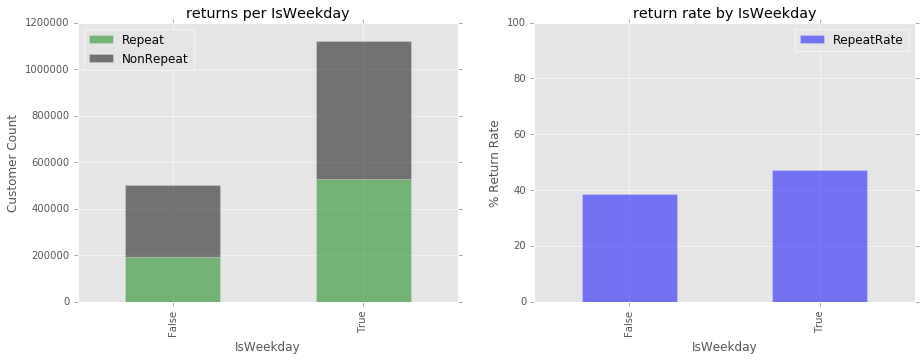

In [600]:
plot_rrate(df, ['IsWeekday'])

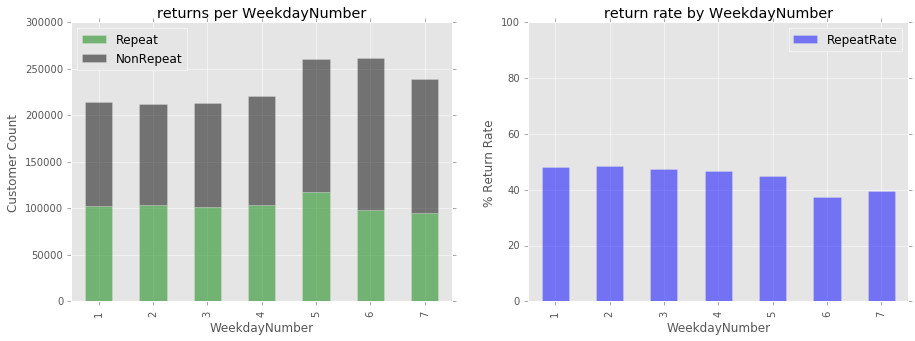

In [601]:
plot_rrate(df, ['WeekdayNumber'])

### impact of seasonality on repeat business
- Sales seem normally distributed across months
- Return rate is steady across months (slightly higher in January)

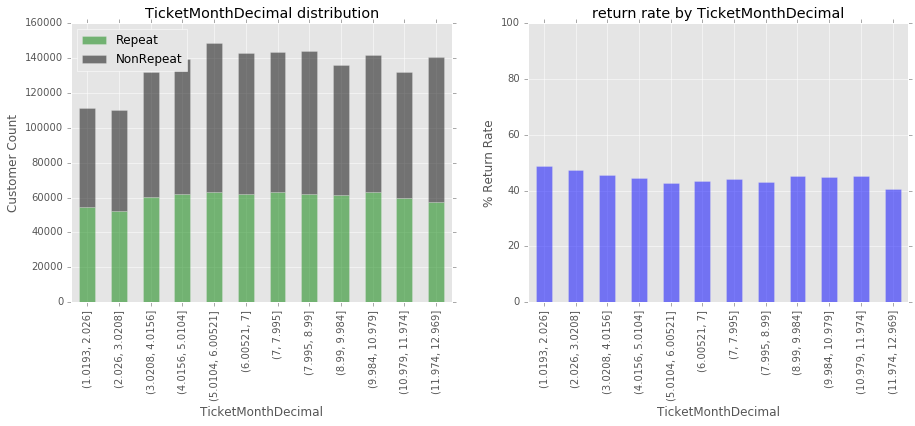

In [602]:
plot_rrate_hist(df, 'TicketMonthDecimal', 12)

### time of day VS repeat business
- of course, sales are focussed around 12PM - 7PM, with outliers on either end
- repeat business is slightly more likely between 9AM-11AM and at 6PM

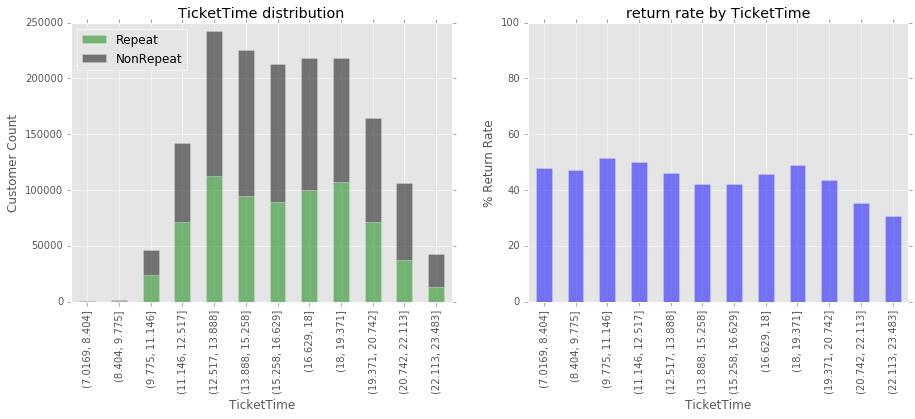

In [603]:
plot_rrate_hist(df, 'TicketTime', 12)

### produce shopping VS repeat business
- Feature 'BoughtProduce' comes from domain knowledge about customer behavior
- Produce shopping must be done locally (natural filter for tourists)
- Fresh produce is uniquely "Italian"... maybe these shoppers use Eataly as a grocery store

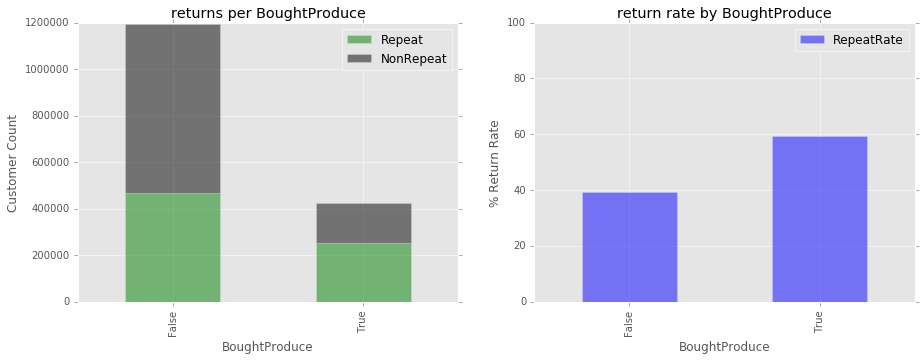

In [604]:
plot_rrate(df, ['BoughtProduce'])

### returning bags VS repeat business
- Another feature from domain knowledge
- Eataly refunds customers $0.05 for returning shopping bags
- This would definintely suggest prior visits on by the customer
- Far more customers do no return bags (98%), so feature may not work

In [605]:
get_rrate(df, ['ReturnedBags'])

,Repeat,NonRepeat,CustCount,CustDist,RepeatRate,RepeatDist
ReturnedBags,,,,,,
False,710691,893775,1604466,98.930456,44.294550,98.554461
True,10424,6922,17346,1.069544,60.094546,1.445539


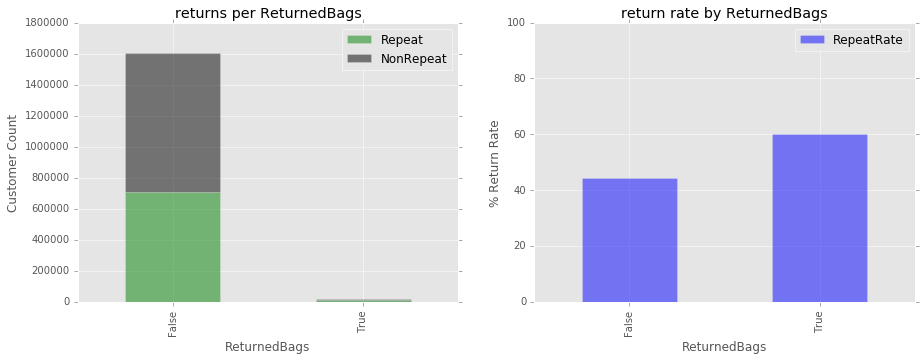

In [606]:
plot_rrate(df, ['ReturnedBags'])

### Net spend vs repeat business
- First pair of graphs show spending distributions from 25th - 75th percentiles
- Second pair of graphs show spending distributions from \$0 - $250
- Both pairs suggest natural tendancy towards smaller dollar value tickets, but constant probability of return

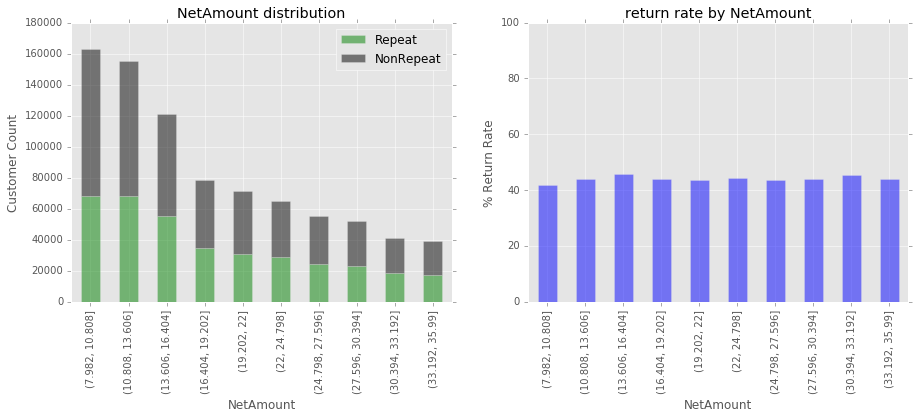

In [607]:
# frequency & probability for spenders between $0 and $250 (to account for outliers in sales)
plot_rrate_hist(df[(df['NetAmount']<36) & (df['NetAmount']>8)], 'NetAmount',10)

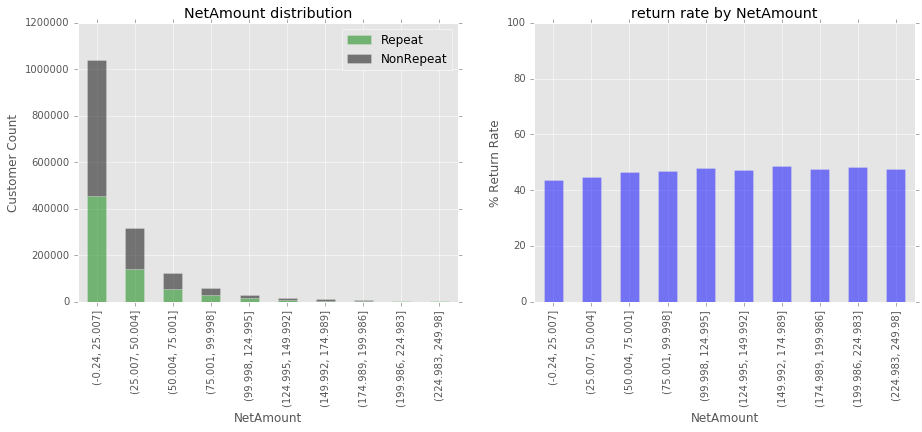

In [608]:
# frequency & probability for spenders between $0 and $250 (to account for outliers in sales)
plot_rrate_hist(df[(df['NetAmount']<250) & (df['NetAmount']>0)], 'NetAmount',10)

### inspecting into correlation of features
- as expected, some features have very high correlations
    - Sales Lines & Net Amount
    - Net Amount & Net Retail Amount
    - Sale Lines & Unique Items


- ML algorithm will have to accomodate highly-correlated features

In [609]:
# find correlations between 
Xcorr = X.corr()
Xcorr.where((Xcorr >.5) & (Xcorr < 1),'')

,TicketTime,PriorVisits,SaleLines,ReturnLines,GiftCardLines,NetAmount,NetRetailAmount,NetQSRAmount,DiscountAmount,UniqueItems,UniqueCategories,ReturnedBags,BoughtProduce,TicketMonthDecimal,WeekdayNumber,IsWeekday,IsFrontEnd
TicketTime,,,,,,,,,,,,,,,,,
PriorVisits,,,,,,,,,,,,,,,,,
SaleLines,,,,,,0.772714,0.785757,,,0.980805,0.844837,,0.508431,,,,
ReturnLines,,,,,,,,,,,,0.687726,,,,,
GiftCardLines,,,,,,,,,,,,,,,,,
NetAmount,,,0.772714,,,,0.96559,,,0.747154,0.646295,,,,,,
NetRetailAmount,,,0.785757,,,0.96559,,,,0.7636,0.675023,,,,,,
NetQSRAmount,,,,,,,,,,,,,,,,,
DiscountAmount,,,,,,,,,,,,,,,,,
UniqueItems,,,0.980805,,,0.747154,0.7636,,,,0.867877,,0.532414,,,,


### applying k-means clusters as a feature
- from preliminary analysis, k-means clusters seem well-defined and intuitive from a business perspective
- the goal of this project is to better understand and segment customers, so clustering is very important

In [ ]:
# finding the elbow plotting inertia
k = []
i = []
for n in range(1,20):
    km2 = KMeans(n_clusters=n)
    km2.fit(X_train)
    k.append(n)
    i.append(km2.inertia_)
    
plt.plot(k, i);